<b><u><i><h1 align="center">Scene Text Detection, Recognition & Translation</h1></i></u></b>

# 1. Overview/ Problem Statement

* The need for computer vision in text detection and recognition from an image or video is getting very popular these days. Because, text is to reliably and effectively spread or acquire information across time and space. In this sense, text constitutes the cornerstone of human civilization.
* This approach can be used for handwriting recognition, natural scene text
detection and recognition, vehicle number detection and recognition and many
more. But multiple challenges may still be encountered when detecting and recognizing text in the scene.
* Few of the challenges are as follows:
<br>1] Text in images exhibit much higher diversity and variability especially for natural scene images.
For example, instances of scene text can be in different languages, colors, fonts, sizes, orientations, and shapes.
<br>2] The backgrounds of natural scenes are virtually unpredictable. Ther might be patterns extremely similar to text (e.g., tree leaves, traffic signs, bricks, windows, and stockades), or occlusions caused by foreign objects, which may potentially lead to confusion and mistakes.
<br>3] In some circumstances, the quality of text images and videos could not be guaranteed. That is, in poor imaging conditions, text instances may be of low resolution and severe distortion due to inappropriate shooting distance or angle, or blurred because of out of focus or shaking, or noise on account of low light level, or corrupted by highlights or shadows. 

# 2. Real-world/Business objectives and constraints

* The main objective of this case study is to build a system that can detect and recognize a text from a natural scene image and then can be translated to another language that an end-user can understand.
* As captured natural scenes images may be blurred, noisy, and in low quality, or multi-oriented(rotated/ curved).
* So, we have to deal with this problem also. To overcome this before detecting the text from those regions there are several steps needed for processing the image to deblur and de-noising it.

# 3. Data

* The scope of this project is limited to only one language for detecting text
and then converting it to another language after recognition.
*  For this project, I've chosen the ICDAR 2015 dataset which contains images
for english word-level text.
<br>a) The ICDAR15 dataset contains 1,500 images: 1,000 for training and
500 for testing. Specifically, it contains 2,077 cropped text instances,
including more than 200 irregular text samples.
<br>b) As text images were taken by Google Glasses without ensuring the
image quality, most of the text is very small, blurred, and
multi-oriented.
<br>c) No lexicon is provided.
* The whole dataset can be downloaded from <a href="https://rrc.cvc.uab.es/?ch=4&com=downloads" target="_blank">here</a>.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g5ZgeWOXMZPIFvDGms0qfctLaC304zy-K-5ji36E5jIhx5FrQK1w9c
Mounted at /content/drive


In [ ]:
cd drive/My Drive/AAIC CS2

/content/drive/My Drive/AAIC CS2


#### Importing packages

In [ ]:
!pip install pytesseract
!sudo apt install tesseract-ocr
import numpy as np
import pandas as pd
import os
import random
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pytesseract
import shutil
import string
import argparse
import torch
import torch.backends.cudnn as cudnn
import torch.utils.data
import torch.nn.functional as F
from imutils.object_detection import non_max_suppression
import time
from tqdm import tqdm
import re
from PIL import Image, ImageFont, ImageDraw
from collections import Counter
import joblib
import spell_corrector as sc

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=e10ea4e844c7e51692ed0fc0fb2f948973ddefff289e863a10d312200a36e36b
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http:/

## 3.1. Data Overview

* An ICDAR 2015 images are blurred, noisy, multi-oriented, rotated or curved and in low quality.
* A training set of 1000 images containing about 4500 readable words will be provided through the downloads section.
* Different ground truth data is provided for each task.
* All images are provided as JPG files and the text files are UTF-8 files with CR/LF new line endings.
*  The ground truth is given as separate text files (one per image) where each line specifies the coordinates of one word's bounding box and its transcription in a comma separated format.
* There is total of 1000 train images and 500 test images.
* Total size of ICDAR15 dataset for both train and test image is 129 MB.

## 3.2. Structure of /root directory dataset

<pre>
<h3>Dataset</h3> 
<ul>
<li>ICDAR15</li>
<ul>
<li>Train</li>
<ul><li>img_1.jpg</li></ul>
<ul><li>img_2.jpg</li></ul>
<ul>...</ul>
<ul><li>img_1000.jpg</li></ul>
</ul>
<ul>
<li>Test</li>
<ul><li>img_1.jpg</li></ul>
<ul><li>img_2.jpg</li></ul>
<ul>...</ul>
<ul><li>img_500.jpg</li></ul>
</ul>
<ul>
<li>Train_localization_transcription_gt</li>
<ul><li>gt_img_1.txt</li></ul>
<ul><li>gt_img_2.txt</li></ul>
<ul>...</ul>
<ul><li>gt_img_1000.txt</li></ul>
</ul>
<ul>
<li>Test_localization_transcription_gt</li>
<ul><li>gt_img_1.txt</li></ul>
<ul><li>gt_img_2.txt</li></ul>
<ul>...</ul>
<ul><li>gt_img_500.txt</li></ul>
</ul>
</ul>
</pre>

# 4. Exploratory Data Analysis

## 4.1. Displaying few sample datapoint

### Displaying a few random images

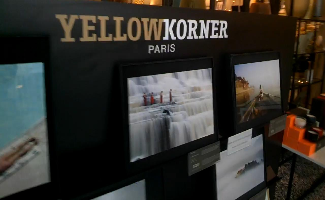

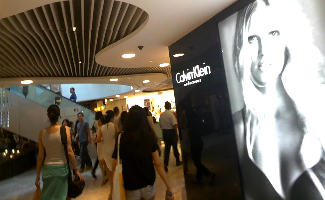

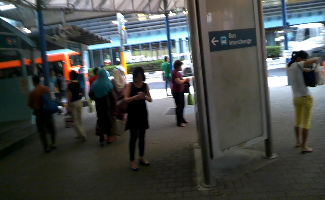

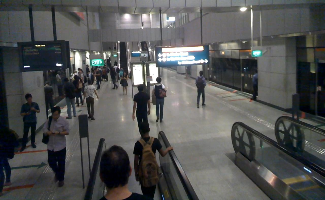

In [ ]:
#lst = [random.randint(1,1000) for i in range(4)]
img_lst = []
index = 0
for i in lst:
  img_lst.append(cv2.resize(cv2.imread('Dataset/ICDAR15/Train/img_'+str(i)+'.jpg'),(325,200)))
  cv2_imshow(img_lst[index])
  index += 1

### Sample file (gt_img_1.txt) which has ground truth for each word of img_1.jpg with their co-ordinates

<pre>
377,117,463,117,465,130,378,130,Genaxis Theatre<br>
493,115,519,115,519,131,493,131,[06]<br>
374,155,409,155,409,170,374,170,###<br>
492,151,551,151,551,170,492,170,62-03<br>
376,198,422,198,422,212,376,212,Carpark<br>
494,190,539,189,539,205,494,206,###<br>
374,1,494,0,492,85,372,86,###<br>
</pre>

Note: Anything that follows the eighth comma is part of the transcription, and no escape characters are used. "Do Not Care" regions are indicated in the ground truth with a transcription of "###".



### Plotting ground truth of one sample file (gt_img_1.txt) which has ground truth for each word of img_1.jpg with their co-ordinates

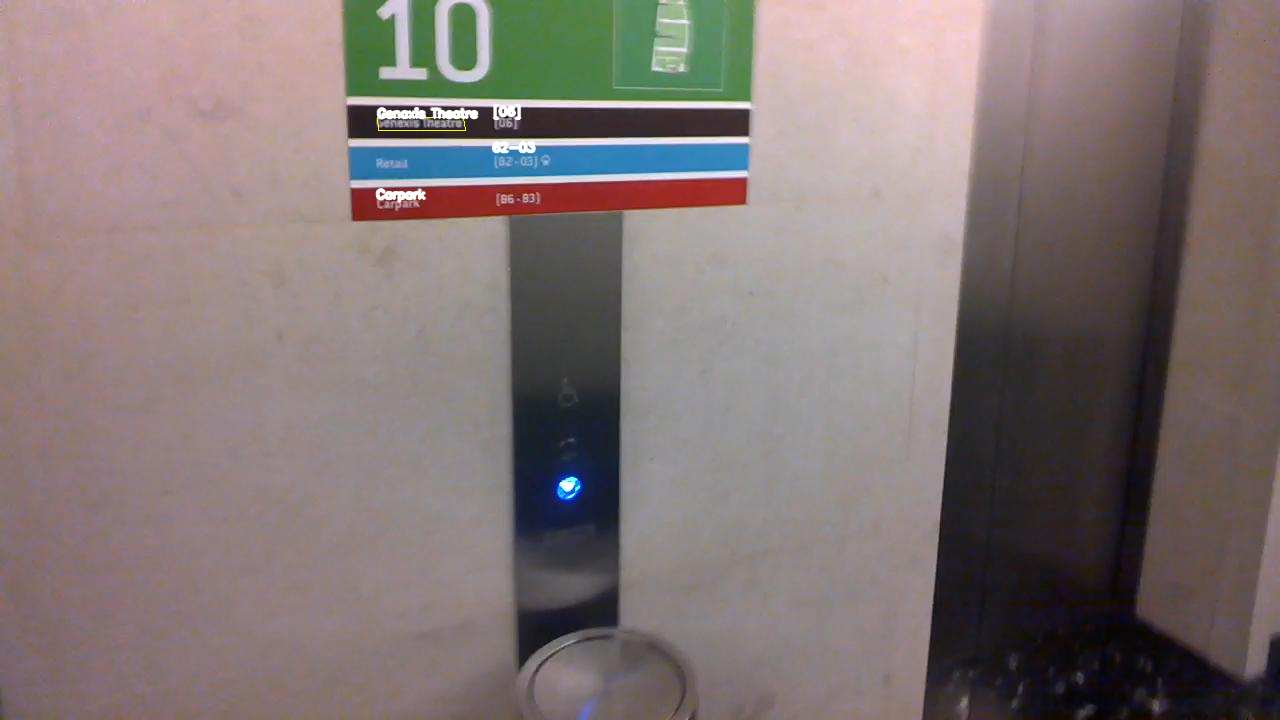

In [ ]:
pts = np.array([[[377,117],[463,117],[465,130],[378,130]],[[493,115],[519,115],[519,131],[493,131]],\
               [[492,151],[551,151],[551,170],[492,170]],[[376,198],[422,198],[422,212],[376,212]]])
gt = ['Genaxis Theatre','[06]','62-03','Carpark']
img = cv2.imread('Dataset/ICDAR15/Train/img_1.jpg')
img = cv2.polylines(img,[pts[0]],True,(0,255,255))
for i in range(len(pts)):
  img = cv2.putText(img, gt[i], tuple(pts[i][0]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 2, cv2.LINE_AA)
cv2_imshow(img)

## 4.2. Creating dataframe with image location and it's correspond ground truth

In [ ]:
#Getting path of all train and test images

train_image_path, test_image_path = [], []
for i in os.listdir('Dataset/ICDAR15/Train/'):
    train_image_path.append('Dataset/ICDAR15/Train/'+i)
for i in os.listdir('Dataset/ICDAR15/Test/'):
    test_image_path.append('Dataset/ICDAR15/Train/'+i)

In [ ]:
#Getting ground truth value of train dataset images

data_gt = []
for i in os.listdir('Dataset/ICDAR15/Training_localization_transcription_gt/'):
    data_gt.append(list(pd.read_table('Dataset/ICDAR15/Training_localization_transcription_gt/'+i,names=['a'])['a'].values))

train_image_gt,train_corpus = [],[]
for i in data_gt:
    temp = ""
    for j in i:
        gt = j.split(',')[-1]
        if gt != '###':
            temp += gt + "|"
            train_corpus.append(gt.lower())
    train_image_gt.append(temp[:-1])

In [ ]:
#Getting ground truth value of test dataset images

data_gt = []
for i in os.listdir('Dataset/ICDAR15/Test_localization_transcription_gt/'):
    data_gt.append(list(pd.read_table('Dataset/ICDAR15/Test_localization_transcription_gt/'+i,names=['a'])['a'].values))

test_image_gt = []
for i in data_gt:
    temp = []
    for j in i:
        gt = j.split(',')[-1]
        if gt != '###':
            temp.append(gt)
    test_image_gt.append(temp[-1])

In [ ]:
#Saving  train and test ground truth corpus
joblib.dump((train_corpus,test_corpus),open('save/corpus.pkl','wb'))

In [ ]:
#Creating a pandas dataframe with image path and its ground truth value

train_df = pd.DataFrame(list(zip(train_image_path, train_image_gt)), columns =['path', 'gt'])
test_df = pd.DataFrame(list(zip(test_image_path, test_image_gt)), columns =['path', 'gt'])

In [ ]:
#Saving train and test dataframe
joblib.dump((train_df,test_df),open('save/data.pkl','wb'))

In [ ]:
#Getting total dataset corpus that is all the words of train and test ground truth with their frequency in whole corpus

corpus = []
corpus.extend(train_corpus)
corpus.extend(test_corpus)
corpus_dict = Counter(corpus)
joblib.dump(corpus_dict,'save/corpus_dict.pkl')

In [ ]:
#Loading train, test dataframe and corpus
train_df,test_df = joblib.load(open('save/data.pkl','rb'))
train_corpus,test_corpus = joblib.load(open('save/corpus.pkl','rb'))
my_dictionary = joblib.load('save/corpus_dict.pkl')
opt = joblib.load('save/opt.pkl')
char_acc_arr,word_acc_arr = joblib.load('save/test_acc.pkl')

In [ ]:
train_df.head()

path                                  gt
0     Dataset/ICDAR15/Train/img_1.jpg  Genaxis Theatre|[06]|62-03|Carpark
1    Dataset/ICDAR15/Train/img_10.jpg               HarbourFront|CC22|bua
2   Dataset/ICDAR15/Train/img_100.jpg               Way|out|Line|Platform
3  Dataset/ICDAR15/Train/img_1000.jpg                                    
4   Dataset/ICDAR15/Train/img_101.jpg               CARE|STICKER|FOR|MORE

## 4.3. Total text instances and unique text instances in dataset

In [ ]:
total_train_text_instance = len(train_corpus)
total_test_text_instance = len(test_corpus)
print('-'*100)
print('Total number of text instances in whole dataset images is {0}.'.format(total_train_text_instance+total_test_text_instance))
print('There are total of {0} text instances for ground truth of train images.'.format(total_train_text_instance))
print('There are total of {0} text instances for ground truth of test images.'.format(total_test_text_instance))
print('-'*100)
print('Total number of unique text instances in whole dataset images is {0}.'.format(len(set(train_corpus))+len(set(test_corpus))))
print('There are total of {0} unique text instances for ground truth of train images.'.format(len(set(train_corpus))))
print('There are total of {0} unique text instances for ground truth of test images.'.format(len(set(test_corpus))))
print('-'*100)

----------------------------------------------------------------------------------------------------
Total number of text instances in whole dataset images is 6545.
There are total of 4468 text instances for ground truth of train images.
There are total of 2077 text instances for ground truth of test images.
----------------------------------------------------------------------------------------------------
Total number of unique text instances in whole dataset images is 3558.
There are total of 2374 unique text instances for ground truth of train images.
There are total of 1184 unique text instances for ground truth of test images.
----------------------------------------------------------------------------------------------------


## 4.4. Getting the number of images with different dimension, channels & extension

In [ ]:
#Getting dimension, channels & extension of each image

dim_list, channel_list, ext_list = [], [], []
for path in train_df['path'].values:
  img = cv2.imread(path)
  dim_list.append(img.shape[:2])
  channel_list.append(img.shape[2])
  ext_list.append(path.split('.')[-1])
print('Unique dimension of all images:',set(dim_list))
print('Unique channels of all images:',set(channel_list))
print('Unique extesions of all images:',set(ext_list))

Unique dimension of all images: {(720, 1280)}
Unique channels of all images: {3}
Unique extesions of all images: {'jpg'}


Observation
* As we can observe, randomly displayed above images are not displaying small text regions clearly that means images are blurred.
* Also as we know the size of whole dataset is 129 MB and there are total of 1500 images, 1000 for train and 500 for test.
* So on an average each image is of size 88 kb which is very small.
* As we can see all images in dataset is of same dimesnion (i.e. (720,1080)).
* All images has 3 channels that means, all are colored images with RGB channels.
* All images has extension of jpg.

# 5. Baseline or traditional methods for text detection & recognition

## 5.1. Text Detection using MSER

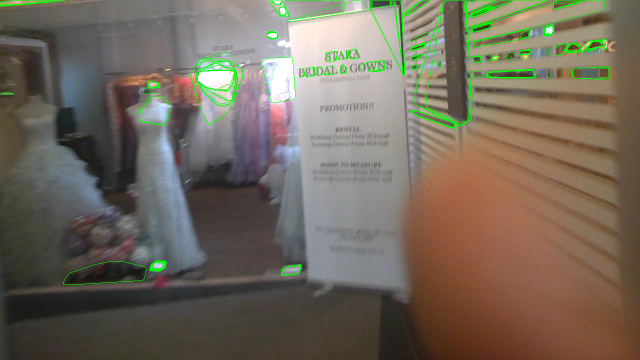

In [ ]:
#Create MSER object
mser = cv2.MSER_create()

#Reading image
img = cv2.imread(train_df.tail()['path'].values[0])

#Convert to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Detect regions in gray scale image
regions, _ = mser.detectRegions(gray)

#Hulls for each dtected regions
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

#Drawing polylines on image
cv2.polylines(img, hulls, 1, (0, 255, 0))

#Showing image with polylines on detected text in an image
cv2_imshow(cv2.resize(img,(640,360)))

Observation
* As we can observe, MSERs have limited performances on blurred or noisy images and textured images.
* Both cases are actually related to the image scale, since blur (which can distort shapes of extracted MSERs) is equivalent to image down-scaling.
* MSER is not suitable for rotated or curved, word-level text detection because it can detect one word as multiple characters.
* Also as we can see, MSER also detects some unwanted or say no-textual region in our case.

## 5.2. Text Recognition using Pytesseract

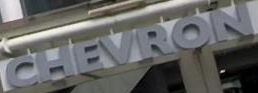

Recognized text:  
 



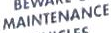

Recognized text: oer cath
AMAINTENANCE
 



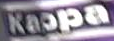

Recognized text:  



Recognized text:  



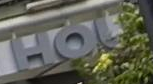

Recognized text:  
 



Recognized text: CAUTION
 



Recognized text: VO
 



In [ ]:
'''
words folder contains few cropped text instances from our ICDAR15 dataset.
Text instances is collected with different characteristics like blurred, rotated, distorted, very small, etc.
'''
for i in os.listdir('words'):
  img = cv2.imread('words/'+i)
  cv2_imshow(img)
  print('Recognized text:',pytesseract.image_to_string(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)),'\n')

Observation
* Pytesseract is not 100% accurate, has its own limitation.
* As we can observe blurred, rotated, small images are either recognized incorrectly or not recognizes any text.
* So, Pytesseract ocr engine recognizes accurate text mostly for horizontal text instance but for rotated or curved text instance it may not work well.

# Modern or Deep learning based text detection, recognition & traslation

# 6. EAST (Efficient accurate scene text detector) text detection with pytesseract text recognition

## 6.1. EAST text detection

In [ ]:
def EAST_text_detector(path):
	'''
	'''
	pred,coords = [],[]
	#Loading the input image
	image = cv2.imread(path)
	
	#image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15) 
	#image = cv2.fastNlMeansDenoising(image)
	#kernel = np.ones((3,3),np.float32)/10
	#image = cv2.filter2D(image,-1,kernel)
	#image = cv2.bilateralFilter(image, 9, 75, 75)

	original_image_copy = image.copy()
	temp = image.copy()
	#Converting the image to gray scale
	temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)

	(H, W) = image.shape[:2]
	#Setting the new width and height and then determine the ratio in change for both the width and height
	(newW, newH) = (512, 288)
	rW = W / float(newW)
	rH = H / float(newH)
	#Resizing the image and taking the new image dimensions
	image = cv2.resize(image, (newW, newH))
	(H, W) = image.shape[:2]

	#Setting the output layer set

	layers = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]
	
	#print("Loading EAST text detector...")
	east_net = cv2.dnn.readNet('models/frozen_east_text_detection.pb')
	#Constructing a blob from the image and then performing a forward pass of the model to obtain the two output layer sets
	mean_color = np.average(image, axis=1)
	mean_bgr = np.average(mean_color, axis=0)
	mean_rgb = tuple([mean_bgr[2],mean_bgr[1],mean_bgr[0]])
	blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), mean_rgb, swapRB=True, crop=False)

	start = time.time()
	east_net.setInput(blob)

	(scores, geometry) = east_net.forward(layers)
	end = time.time()
	#print("Text detection model has been loaded in {:.4f} seconds".format(end - start))

	#Taking the number of rows and columns from the scores volume, then initializing our set of bounding box rectangles
	#and corresponding confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects, confidences = [], []
	for y in range(0, numRows):
		#Extracting the scores (probabilities), followed by the geometrical data used to derive potential bounding box
  	#coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		for x in range(0, numCols):
			#If our score does not have sufficient probability, ignore it
			if scoresData[x] < 0.5:
				continue
			#Computing the offset factor as our resulting feature maps will be 4 times smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)
			#Extracting the rotation angle for the prediction and then computing the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)
			#Using the geometry volume to derive the width and height of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]
			#Computing both the starting and ending (x, y)-coordinates for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)
			#Adding the bounding box coordinates and probability score to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	#Applying non-maxima suppression to suppress weak, overlapping bounding boxes
	boxes = non_max_suppression(np.array(rects), probs=confidences)

	for (startX, startY, endX, endY) in boxes:
		#Scaling the bounding box coordinates based on the respective ratios
		startX = int(startX * rW) - 2
		startY = int(startY * rH) - 1
		endX = int(endX * rW) + 2
		endY = int(endY * rH) + 2

		#If coords are out of the image dimension resizing it
		if startX < 0:
			startX = 0
		if endX > original_image_copy.shape[1]:
			endX = original_image_copy.shape[1]
		if startY < 0:
			startY = 0
		if endY > original_image_copy.shape[0]:
			endY = original_image_copy.shape[0]

		#Drawing the bounding box on the image
		cv2.rectangle(original_image_copy, (startX, startY), (endX, endY), (0, 255, 0), 2)
		if endX > original_image_copy.shape[1] or endY > original_image_copy.shape[0]:
			endX = original_image_copy.shape[1]
			endY = original_image_copy.shape[0]
		coords.append((startY, endY, startX, endX))
  
	return cv2.cvtColor(original_image_copy, cv2.COLOR_BGR2GRAY), coords

## 6.2. Pyteserract text recognition

In [ ]:
def pytesseract_text_recognizer(image,coords):
  '''
  This function accepts the image and its detected text region coordinates
  and returns predictions using pytesseract ocr
  '''

  pred = []
  #Configuration setting to convert image to string.  
  configuration = ("-l eng --oem 3 --psm 12")
  '''
  l: language, chosen English in the above code.

  oem(OCR Engine modes):
  0    Legacy engine only.
  1    Neural nets LSTM engine only.
  2    Legacy + LSTM engines.
  3    Default, based on what is available.

  psm(Page segmentation modes):
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
  10    Treat the image as a single character.
  11    Sparse text. Find as much text as possible in no particular order.
  12    Sparse text with OSD.
  13    Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.
  '''
  temp = ""
  for i in range(len(coords)):
    startY, endY, startX, endX = coords[i]
    temp = pytesseract.image_to_string(image[startY : endY, startX : endX], config=configuration).strip()
    pred.append(sc.correction(temp))
  pred_ = pred.copy()

  #Clean predictions
  pred = re.sub(r"\n", " ", " ".join(pred))
  pred = re.sub(r"\t", " ", pred)
 
  return pred,pred_

## 6.3. End-to-End text detection & recognition (EAST with Pytesseract)

In [ ]:
def EAST_with_Pyserract(path,gt):
  '''
  This function integrated the EAST text detection and pytesseract text recognition
  which accepts the image path, ground truth and returns actual vs predicted text,
  word-level accuracy.
  '''
  image, coords = EAST_text_detector(path)
  recognized_op,pred_ = pytesseract_text_recognizer(image, coords)
  pred = recognized_op.lower().split()
  actual = gt.lower().split('|')
  y_true = 0
  for i in pred:
    for j in actual:
      if i == j:
        y_true +=1
  print('Actual text instances:',actual)
  print('Predicted text instances:',pred)
  print('\nNumber of correctly recognized word:',y_true)
  print('Number of incorrectly or not recognized word:',len(actual)-y_true)
  print('\nAccuracy:',(y_true*100)/(len(actual)),'%\n')
  print('-'*75,'\n')

  color_image = cv2.imread(path)
  for i in range(len(coords)):
    startY, endY, startX, endX = coords[i]
    cv2.rectangle(color_image, (startX, startY), (endX, endY), (0, 255, 0), 2)
    cv2.putText(color_image, pred_[i], (startX, startY-7), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255), 2)
  cv2_imshow(cv2.resize(color_image,(512,384)))

  return y_true,len(actual)-y_true,(y_true*100)/(len(actual))

Actual text instances: ['joint', 'yourself', '154', '197', '727', '198', '20029', 'free', 'from', 'pain']
Predicted text instances: ['free', 'yourself', 'from', 'joint', 'pain', 'pte']

Number of correctly recognized word: 5
Number of incorrectly or not recognized word: 5

Accuracy: 50.0 %

--------------------------------------------------------------------------- 



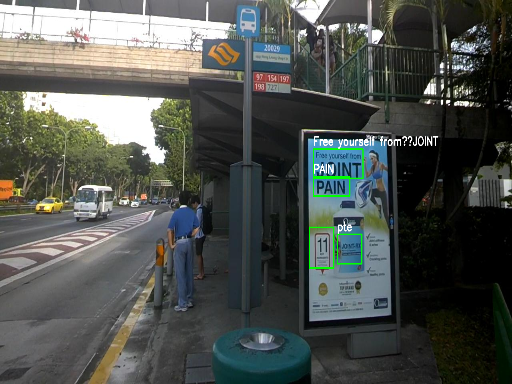

In [ ]:
y_true,y_false,acc = EAST_with_Pyserract(test_df['path'].values[111],test_df['gt'].values[111])

Observation
* The EAST text detection model with pytesseract text recognition model works well as compared to our baseline model.
* The EAST model finds bounding box of text instance very well for clearly visible instances but for small, rotated or noisy instance it doesn't work very well.
* Pytesseract ocr engine recognizes accurate text mostly for horizontal text instance but for rotated or curved text instance it is not working as per our expectations. 
* So, we can conclude that EAST with pytesseract text detection and recognition works well but only for horizontal and nice quality image.
* But in our case its performance is like a random model that may work well but not in every case or in very few case.

# 7. EasyOCR text detection & recognition

In [ ]:
!pip install easyocr
import easyocr
reader = easyocr.Reader(['en'])

     |████████████████████████████████| 62.4MB 44kB/s 


In [ ]:
def easyocr_engine(path):
  '''
  This function returns the coords for detected text using easyOCR
  '''
  coords = []
  
  #Reading image using cv2
  image = cv2.imread(path)
  image_copy = image.copy()
  image_copy1 = image.copy()

  #Getting predictions using EasyOCR which is array of coords, recognized text & confidence percentage
  op = reader.readtext(image)

  #Drawing polygon on images using predicted coords and putting recognized text onto it
  for i in range(len(op)):

    #pts contains coords for each detected text
    pts = np.array(op[i][0])
    coords.append(np.int32(pts))
    
    #Drawing a polygon on original image
    cv2.polylines(image, np.int32([pts]),True,(0,255,0),2)
    cv2.polylines(image_copy1, np.int32([pts]),True,(0,255,0),2)
    
    #Putting text near detected text regions
    cv2.putText(image, sc.correction(op[i][-2]), (int(op[i][0][0][0]), int(op[i][0][0][1]-7)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)
  
  #Displayig the image with bounding boxes of detected region and text near it
  cv2_imshow(cv2.resize(image,(512,384)))

  return image_copy,image_copy1, coords

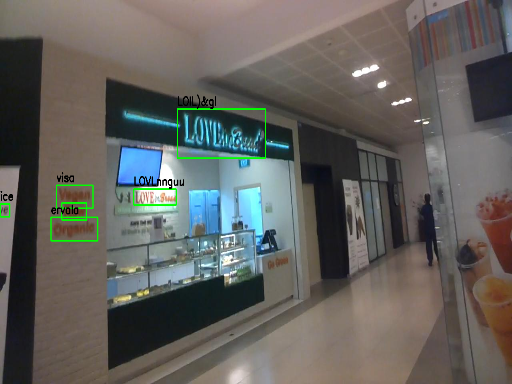

In [ ]:
_,_ = easyocr_engine(test_df['path'].values[11])

## EasyOCR text detection & recognition on few sample images

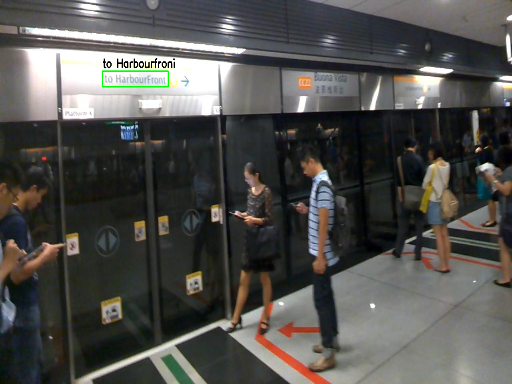

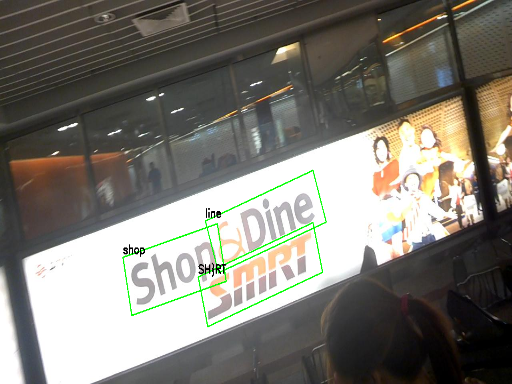

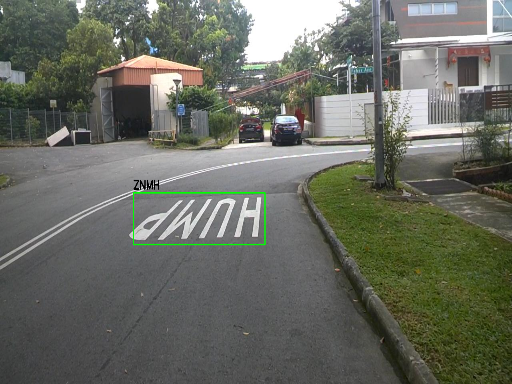

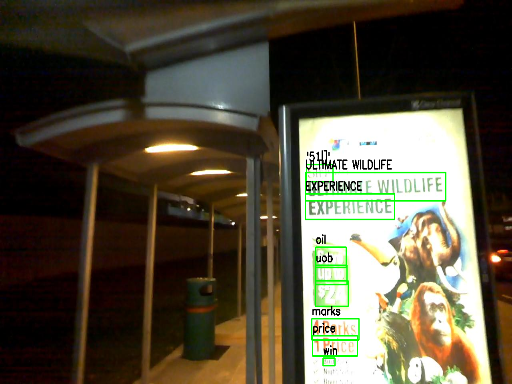

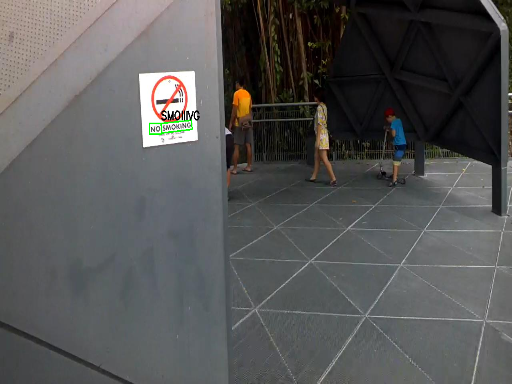

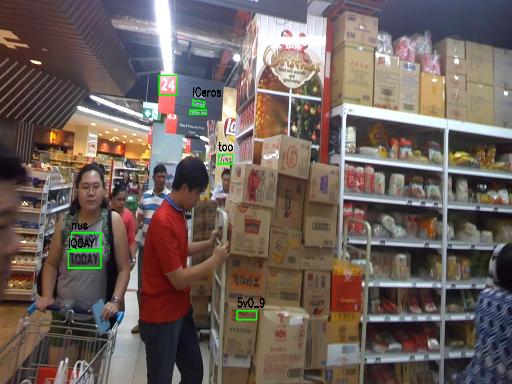

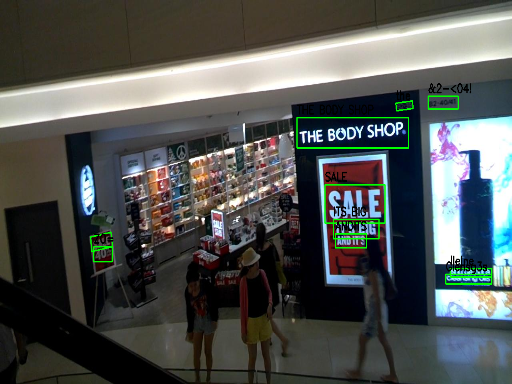

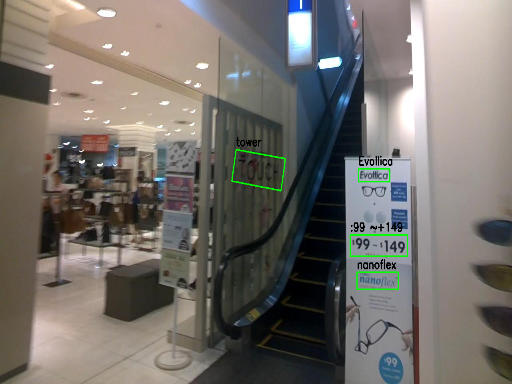

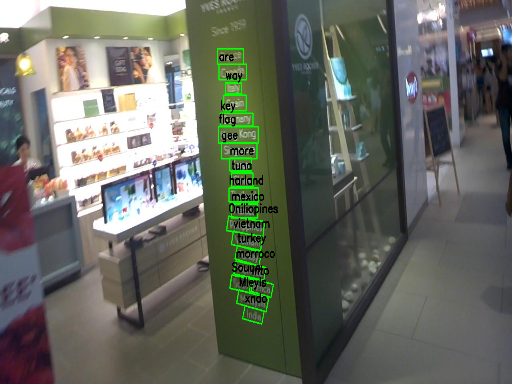

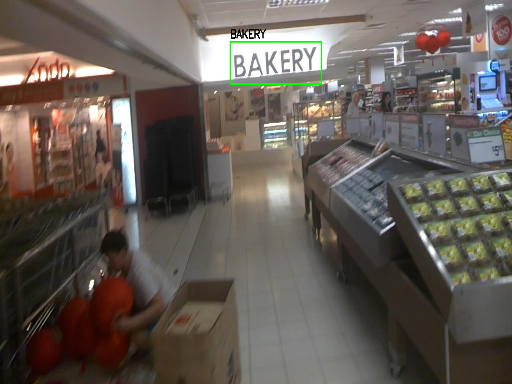

In [ ]:
temp = [1,5,94,154,257,385,759,854,254,953]
for i in temp:
  easyocr_engine(train_df['path'].values[i])

* As we can see, EasyOCR gives better result than EAST text detection and pytesseract text recognition.
* But still while recognizing the text there is some mistakes although the detected text region is quite accurate. Even for rotated and blurred text regions it detects very efficiently.
* So to build the accurate text detection and recognition model, we can combine EasyOCR text detection result and differennt much more accurate text recogition model.

## 8. Text Recognition

* We have seen, EasyOCR models does pretty well job while detectinng the text region from an image although it's recognition is quite good.
* But as we know, our ICDAR15 dataset has lots of rotated, blurred, low-resolution.
* Due to which in some cases text recognition fails.
* So, to improve or get well adequate text recognition result we'll be proposing different recognition model.
* And then we can combine results of EasyOCR text detection with different text recognition model to get more accurate predictions.

> * Our most of the text regions are blurry, rotated(can be clockwise as well as anti-clockwise).
* So to do more accurate recognition we need to apply some kind of transformation on images.
* In most recent years, spatial transformation network became very popular for image transfomration as it allows a neural network to learn how to perform spatial transformations on the input image in order to enhance the geometric invariance of the model.
* For example, it can crop a region of interest, scale and correct the orientation of an image and so on.

![](https://miro.medium.com/max/2400/1*FH9XuJsFCX-zv43QxT0wRw.png)


> * So, after getting N different detected text region we'll be processing those region independently from each other. 
* The processing of the N different regions is handled by a CNN. ResNet based feature extraction will be used to achieves good results if we use a variant of the ResNet architecture for our recognition network.
* We can also integrate BiLSTM (Bi-directional Long Short-Term Memory) sequence model to improve the result by learning not only from beginning-to-end but also from end-to-beginning.

In [ ]:
#Ref: https://github.com/clovaai/deep-text-recognition-benchmark

import sys  
sys.path.insert(0, 'text-recognition')
from utils import AttnLabelConverter
from dataset import RawDataset, AlignCollate
from model import Model

def text_recognition():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  cudnn.benchmark = True
  cudnn.deterministic = True
  opt.num_gpu = torch.cuda.device_count()
  '''model configuration'''
  converter = AttnLabelConverter(opt.character)
  opt.num_class = len(converter.character)
  model = Model(opt)
  model = torch.nn.DataParallel(model).to(device)
  #loading model
  model.load_state_dict(torch.load(opt.mymodel, map_location=device))

  #preparing data
  AlignCollate_demo = AlignCollate(imgH=32, imgW=100)
  my_data = RawDataset(root=opt.image_folder, opt=opt)
  my_data_loader = torch.utils.data.DataLoader(
      my_data, batch_size=192,
      shuffle=False,
      num_workers=8,
      collate_fn=AlignCollate_demo, pin_memory=True)

  #prediction
  result = []
  model.eval()
  with torch.no_grad():
      for image_tensors, image_path_list in my_data_loader:
              batch_size = image_tensors.size(0)
              image = image_tensors.to(device)
              #For max length prediction
              length_for_pred = torch.IntTensor([opt.batch_max_length] * batch_size).to(device)
              text_for_pred = torch.LongTensor(batch_size, opt.batch_max_length + 1).fill_(0).to(device)
              preds = model(image, text_for_pred, is_train=False)

              #selecting max probabilty then decoding index to character
              _, preds_index = preds.max(2)
              preds_str = converter.decode(preds_index, length_for_pred)

              preds_prob = F.softmax(preds, dim=2)
              preds_max_prob, _ = preds_prob.max(dim=2)
              for img_name, pred, pred_max_prob in zip(image_path_list, preds_str, preds_max_prob):
                  pred_EOS = pred.find('[s]')
                  pred = pred[:pred_EOS]  # prune after "end of sentence" token ([s])
                  pred_max_prob = pred_max_prob[:pred_EOS]
                  #calculating confidence score
                  confidence_score = pred_max_prob.cumprod(dim=0)[-1]
                  result.append([img_name,pred,float(confidence_score)])
  
  return result

Image:


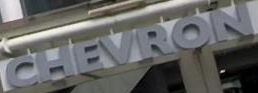

Predicted text: chemboll
Cofidence score: 0.0514216311275959
__________________________________________________
Image:


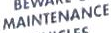

Predicted text: maintenance
Cofidence score: 0.404618501663208
__________________________________________________
Image:


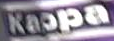

Predicted text: kippa
Cofidence score: 0.4662216007709503
__________________________________________________
Image:


Predicted text: block
Cofidence score: 0.7840110659599304
__________________________________________________
Image:


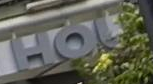

Predicted text: hou
Cofidence score: 0.3050267696380615
__________________________________________________
Image:


Predicted text: dauttion
Cofidence score: 0.04929427430033684
__________________________________________________
Image:


Predicted text: pintu
Cofidence score: 0.9857540130615234
__________________________________________________


In [ ]:
a = text_recognition()
for i in a:
  print('Image:')
  cv2_imshow(cv2.imread(i[0]))
  print('Predicted text:',i[1])
  print('Cofidence score:',i[2])
  print('_'*50)

Image:


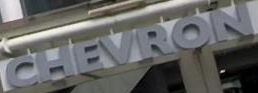

Predicted text: chemboll
Corrected predicted text: chemboll
__________________________________________________
Image:


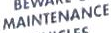

Predicted text: maintenance
Corrected predicted text: maintenance
__________________________________________________
Image:


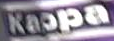

Predicted text: kippa
Corrected predicted text: kappa
__________________________________________________
Image:


Predicted text: block
Corrected predicted text: block
__________________________________________________
Image:


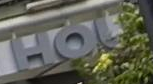

Predicted text: hou
Corrected predicted text: hou
__________________________________________________
Image:


Predicted text: dauttion
Corrected predicted text: caution
__________________________________________________
Image:


Predicted text: pintu
Corrected predicted text: pintu
__________________________________________________


In [ ]:
for i in a:
  print('Image:')
  cv2_imshow(cv2.imread(i[0]))
  print('Predicted text:',i[1])
  print('Corrected predicted text:',sc.correction(i[1]))
  print('_'*50)

* Our text recognition model gives much better result than pytesseract & easyocr text recognition.
* Our text recognition model predicts 4 out of 7 text correctly but still it can be improved further.
* To do so, we have applied our custom spell correction model on top of text recognition prediction.
* After applying our spell correction model it gives 6 out of 7 text correctly which gives 86% accurate result.

# 9. Text Translator (English to Hindi language)

* For text translation from predicted english text to hindi text, we'll use englisttohindi python package.
* In this fnction there is function named EngtoHindi() which translates english text (can be single word as well as sentences) to hindi text very accurately.

In [ ]:
!pip install englisttohindi
!sudo apt-get install fonts-gargi
font_hindi = ImageFont.truetype("/usr/share/fonts/truetype/Gargi/Gargi.ttf",25)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-gargi
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 42.4 kB of archives.
After this operation, 97.3 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 fonts-gargi all 2.0-4 [42.4 kB]
Fetched 42.4 kB in 0s (103 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-gargi.
(Reading database ... 145530 files and directories cur

In [ ]:
from englisttohindi.englisttohindi import EngtoHindi 

def english_to_hindi(text):
  '''
  This function accepts the english sentence or word,
  and converts it to hindi language
  '''
  
  #creating a EngtoHindi() object 
  res = EngtoHindi(text) 
  
  #converting english text to hindi text
  converted_text = res.convert

  return converted_text

In [ ]:
#Translating whole english sentence
english_to_hindi('The taste of coffee is very good.')

'कॉफी का स्वाद बहुत अच्छा है।'

In [ ]:
#Translating english word
english_to_hindi('pain')

'दर्द'

In [ ]:
#Translating non-english word such as name, place, etc.
english_to_hindi('Alexa')

'एलेक्सा'

english_to_hindi() function gives good translation results for english sentences, words, etc.

# 10. Final End-to-End Scene Text Detection, Recognition & Translation

> Building final hybrid text detection, recognition & translation model by combining the easyocr text detection prediction, our own pre-trained text recognition model & pre-trained english to hindi language translation model.

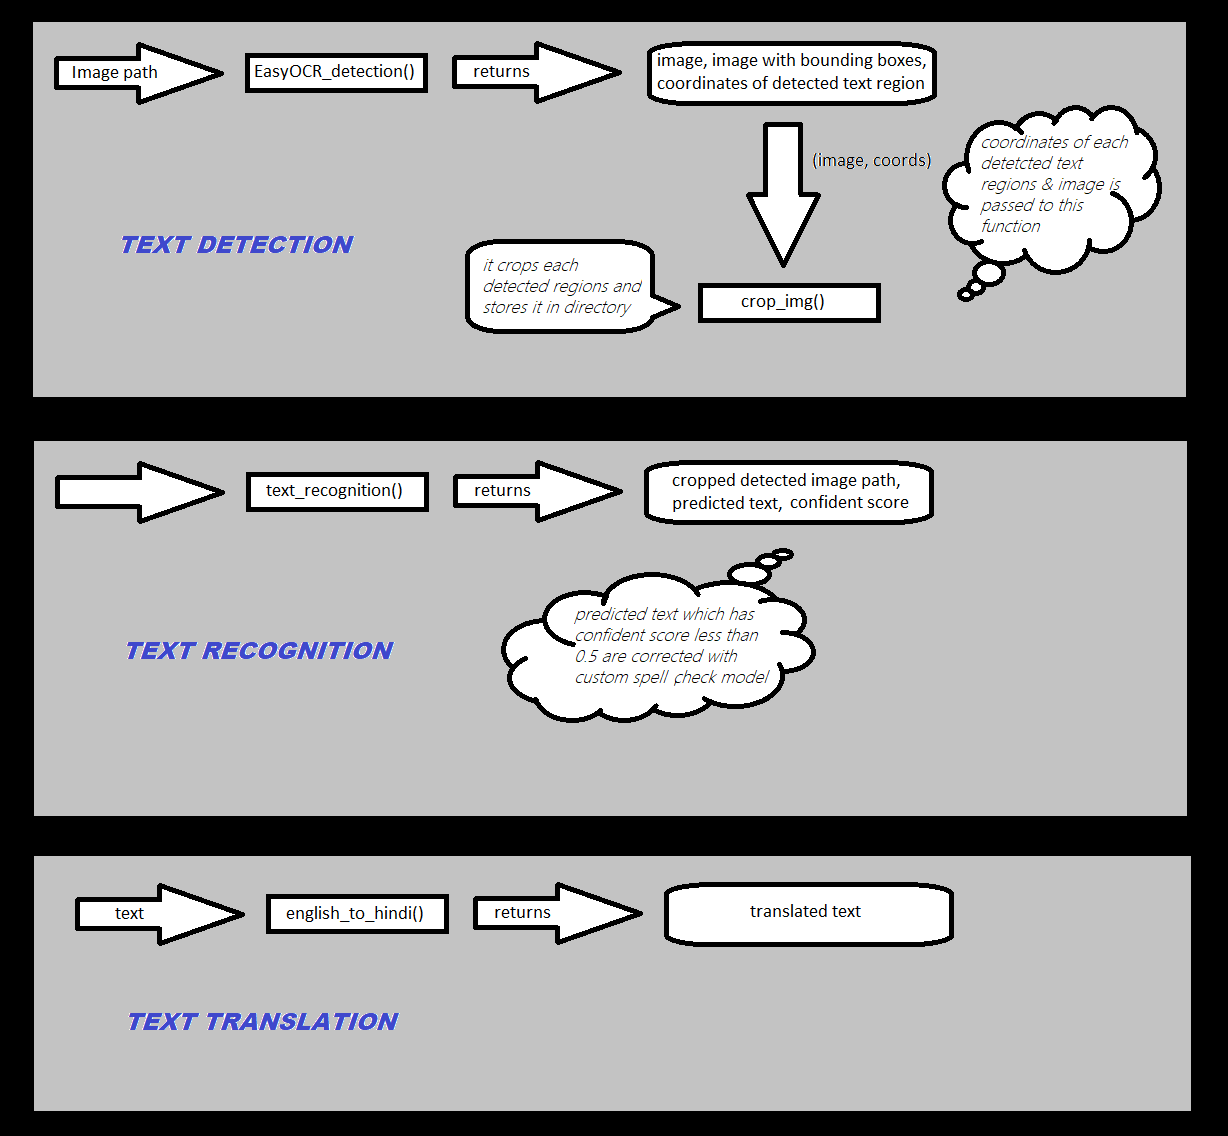

## 10.1 Utility function

In [ ]:
def easyocr_detection(path):
  '''
  This function returns the coords for detected text using easyOCR
  '''
  coords = []
  
  #Reading image using cv2
  image = cv2.imread(path)
  image_copy = image.copy()
  image_copy1 = image.copy()

  #Getting predictions using EasyOCR which is array of coords, recognized text & confidence percentage
  op = reader.readtext(image)

  #Drawing polygon on images using predicted coords and putting recognized text onto it
  for i in range(len(op)):

    #pts contains coords for each detected text
    pts = np.array(op[i][0])
    coords.append(np.int32(pts))
    
    #Drawing a polygon on original image
    cv2.polylines(image, np.int32([pts]),True,(0,255,0),2)
    cv2.polylines(image_copy1, np.int32([pts]),True,(0,255,0),2)

  return image_copy,image_copy1, coords

In [ ]:
def crop_img(img,pts,i):
  '''
  This function crops the image based on detected coordinates
  and saves cropped image and returns cropped image coords of
  original image
  '''

  #cropping the bounding rect
  rect = cv2.boundingRect(pts)
  x,y,w,h = rect
  croped = img[y:y+h, x:x+w].copy()

  #making mask image
  pts = pts - pts.min(axis=0)

  mask = np.zeros(croped.shape[:2], np.uint8)
  cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

  #doing bitwise 'and operation'
  dst = cv2.bitwise_and(croped, croped, mask=mask)

  #adding the white background
  bg = np.ones_like(croped, np.uint8)*255
  cv2.bitwise_not(bg,bg, mask=mask)
  dst2 = bg + dst
  img_path = "detected-text/"+str(i)+".png"

  #saving detected cropped text instance image
  cv2.imwrite(img_path, dst2)

  return (x,y),img_path

In [ ]:
def char_level_accuracy(actual,pred):
  '''
  This function accepts actual and predicted text list or string
  and returns character accuracy of prediction
  '''
  #Splitting gt value by | and making it all lowercase
  actual = actual.lower().split('|')

  #list to string (joining list)
  actual = ''.join(actual)
  pred = ''.join(pred)
  
  #saving frequency of each char for both actual & predicted output
  a_freq, p_freq = {},{}
  for i in actual: 
    if i in a_freq: 
        a_freq[i] += 1
    else: 
        a_freq[i] = 1
  for i in pred: 
    if i in p_freq: 
        p_freq[i] += 1
    else: 
        p_freq[i] = 1

  #Making frequncy of not presented char as 0
  all_char = list(string.ascii_lowercase) + list('0123456789')
  for i in all_char:
    if i not in list(a_freq.keys()):
      a_freq[i] = 0
    if i not in list(p_freq.keys()):
      p_freq[i] = 0

  #counting total number of errors in prediction for each char
  error = 0
  for i in all_char:
    t = a_freq[i] - p_freq[i]
    if t < 0:
      t = 0
    error += t

  if (len(actual) == 0):
    acc = 1
  else:
    acc = (len(actual)-error)/len(actual) #percentage of correctly predicted chars

  return acc

In [ ]:
def word_level_accuracy(actual,pred):
  '''
  This function accepts actual and predicted text list or string
  and returns character accuracy of prediction
  '''
  #Splitting gt value by | and making it all lowercase
  actual = actual.lower().split('|')
  actual = [re.sub('[^a-z0-9]+', '', i) for i in actual]
  total = len(actual)
  pred = ''.join(pred)

  #counting correctly predicted word
  count = 0
  for i in actual:
    if i in pred:
      count += 1

  #calculating percentage of correctly predicted word
  acc = count/total

  return acc

## 10.2 Final model

In [ ]:
def hybrid_text_detection_recongnition_n_translation(path,trans=False):
  '''
  This function is a combination easyoce_engine() function for text prediction,
  text_recognition() function for text recognition and lang_translator()
  function for translator.

  Input: path, trans
  > path is a whole path of input image.
  > trans can be either True or False.
  True means translated recognized text.
  False means don't translate.
  Default value is False.

  After detecting, recognizing and translating text it displays image with the
  bounding box on image and translated text near it.
  '''
  #Calling easyocr_detection() function which returns image,image with bounding-boxes and its detected region coordinates.
  img,img_det,coords = easyocr_detection(path)

  #Removing existing unneeded detetcted cropped image
  for file in os.listdir('detected-text/'):
    os.remove(os.path.join('detected-text/', file))

  #Cropping the image to get individual text region image with its coords in original image
  detected_img_path_n_pts = []
  for index,pts in enumerate(coords):
    for i in range(len(pts)):
      for j in range(len(pts[i])):
        if (pts[i][j] < 0):
          pts[i][j] = 0
    temp,n = crop_img(img,pts,index)
    detected_img_path_n_pts.append(temp)

  #Recognizing text from all cropped text instances image and storing predicted result with its confidence score
  temp = text_recognition()
  temp.sort()
  pred = [i[1] for i in temp]
  conf_score = [i[2] for i in temp]

  pred_ = []
  #Using custom spell corrector modules to correct minor spelling mistakes of recognized text
  for i in range(len(pred)):
    if conf_score[i] <= 0.5:
      pred_.append(sc.correction(pred[i]))
    else:
      pred_.append(pred[i])

  #Putting text near detected text regions
  if trans:
    #Translating predicted text to specified language
    pred_trans = []
    for i in pred_:
      if i.isdigit():
        pred_trans.append(i)
      else:
        pred_trans.append(english_to_hindi(i))
    img_pil = Image.fromarray(img_det)
    draw = ImageDraw.Draw(img_pil)
    for i in range(len(pred_trans)):
      draw.text(detected_img_path_n_pts[i], pred_trans[i], font=font_hindi,fill='black')
    img_det = np.array(img_pil)
  else:
    for i in range(len(pred_)):
      cv2.putText(img_det, pred_[i], detected_img_path_n_pts[i], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

  cv2_imshow(cv2.resize(img_det,(int(1280*0.6),int(720*0.6))))

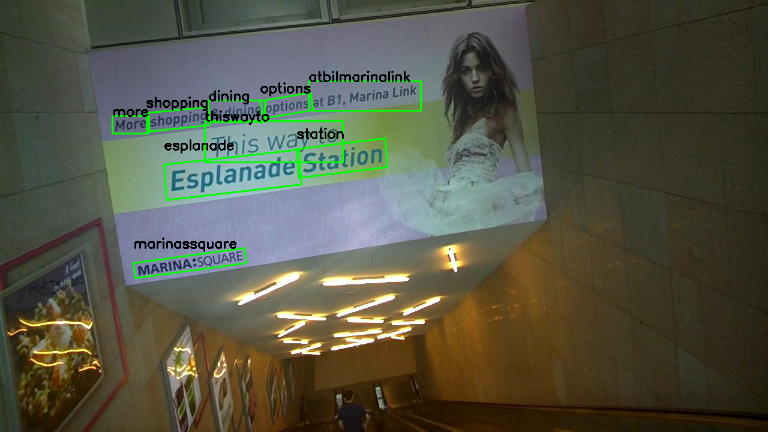

In [ ]:
hybrid_text_detection_recongnition_n_translation(test_df['path'].values[10], trans=False)

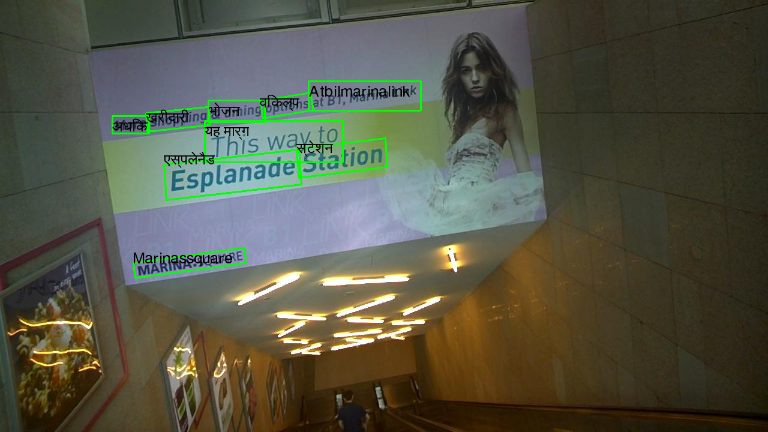

In [ ]:
hybrid_text_detection_recongnition_n_translation(test_df['path'].values[10], True)

## 10.3 Accuracy of the final model

In [ ]:
def calAccuracy_hybrid_text_detection_n_recongnition(path,gt):
  '''
  This function is a combination easyoce_engine() function for text prediction,
  text_recognition() function for text recognition.

  Input: path, gt
  > path is a whole path of input image.
  > gt is ground truth value.
  '''

  #Calling easyocr_detection() function which returns image,image with bounding-boxes and its detected region coordinates.
  img,img_det,coords = easyocr_detection(path)

  #Removing existing unneeded detetcted cropped image
  for file in os.listdir('detected-text/'):
    os.remove(os.path.join('detected-text/', file))

  #Cropping the image to get individual text region image with its coords in original image
  detected_img_path_n_pts = []
  for index,pts in enumerate(coords):
    for i in range(len(pts)):
      for j in range(len(pts[i])):
        if (pts[i][j] < 0):
          pts[i][j] = 0
    temp,n = crop_img(img,pts,index)
    detected_img_path_n_pts.append(temp)

  #Recognizing text from all cropped text instances image and storing predicted result with its confidence score
  temp = text_recognition()
  temp.sort()
  pred = [i[1] for i in temp]
  conf_score = [i[2] for i in temp]

  pred_ = []
  #Using custom spell corrector modules to correct minor spelling mistakes of recognized text
  for i in range(len(pred)):
    if conf_score[i] <= 0.5:
      pred_.append(sc.correction(pred[i]))
    else:
      pred_.append(pred[i])

  #calling function to calculate char & word level accuracy
  char_acc = char_level_accuracy(gt,pred_)
  word_acc = word_level_accuracy(gt,pred_)
  
  return char_acc,word_acc

In [ ]:
char_acc,word_acc = calAccuracy_hybrid_text_detection_n_recongnition(test_df['path'].values[18],test_df['gt'].values[18])
print('Character level accuracy:',char_acc)
print('Word level accuracy:',word_acc)

Character level accuracy: 0.8461538461538461
Word level accuracy: 0.6


In [ ]:
char_acc,word_acc = calAccuracy_hybrid_text_detection_n_recongnition(test_df['path'].values[98],test_df['gt'].values[98])
print('Character level accuracy:',char_acc)
print('Word level accuracy:',word_acc)

Character level accuracy: 1.0
Word level accuracy: 1.0


In [ ]:
#Calculating character and word level accuracy for all test images and storing in a list

char_acc_arr,word_acc_arr = [],[]
for i in range(500):
  a,b = calAccuracy_hybrid_text_detection_n_recongnition(test_df['path'].values[i],test_df['gt'].values[i])
  char_acc_arr.append(a)
  word_acc_arr.append(b)

In [ ]:
print('Average char level accuracy of test images is {0:.2f}%.'.format(np.average(np.array(char_acc_arr)*100)))
print('Average word level accuracy of test images is {0:.2f}%.'.format(np.average(np.array(word_acc_arr)*100)))

Average char level accuracy of test images is 85.69%.
Average word level accuracy of test images is 67.45%.


In [ ]:
#Displaying total % of images which has more than threshold accuracy

#For char level accuracy
temp = 0
for i in sorted(char_acc_arr):
  if i >= 0.6:
    temp += 1
print(temp/len(char_acc_arr)*100,'% of test images has more than 60% of char level accuracy.')

#For word level accuracy
temp = 0
for i in sorted(word_acc_arr):
  if i >= 0.6:
    temp += 1
print(temp/len(word_acc_arr)*100,'% of test images has more than 60% of word level accuracy.')

90.4 % of test images has more than 60% of char level accuracy.
64.4 % of test images has more than 60% of word level accuracy.


# 11. Future Work

* We can build this model with multilingual support.

* It can be improved to not only recognized text of one language but also recognized text can be translated to any native language of end-user.

# 12. Conclusion

* EAST with pytesseract text detection and recognition works well but only for horizontal and nice quality image. But in our case its performance is like a random model that may work well but not in every case or in very few case.
* EasyOCR gives better result than EAST text detection and pytesseract text recognition. But still while recognizing the text there is some mistakes although the detected text region is quite accurate. Even for rotated and blurred text regions.
* Our custom text recognition model gives much better result than pytesseract & easyocr text recognition.
* Pre-trained englisttohindi package gives good translation results for english sentences, words, etc.
* So our final hybrid text detection, recognition and translation model which is combination of easyocr text detection, custom text recognition and pre-trained language translation gives much better result than our previously experimented models.
* With our final model, 90.4 % of test images has more than 60% of char level accuracy and 64.4 % of test images has more than 60% of word level accuracy.

